In [1]:
import cv2
import os
import random
import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import copy
import time 

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../input/training/Labels.csv')
#df['labels'] = df['labels'].apply(lambda x: x - 1) #Because Cross entropy takes 0 to N-1 classes
#df.to_csv('labels_updated.csv')
df.head()

,Unnamed: 0,filenames,labels_code,labels
0,0,img001-001.png,img001,0
1,1,img001-002.png,img001,0
2,2,img001-003.png,img001,0
3,3,img001-004.png,img001,0
4,4,img001-007.png,img001,0


In [4]:
df.labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:

train_transforms = transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize(mean =  [0.49139968, 0.48215841, 0.44653091], 
                                                std = [0.24703223, 0.24348513, 0.26158784])
                       ])

valid_transforms = transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize(mean =  [0.49139968, 0.48215841, 0.44653091], 
                                                std = [0.24703223, 0.24348513, 0.26158784])
                       ])

In [7]:
class mydataset():
    def __init__(self, csv, img_path, transform=None):
        self.labels_df = pd.read_csv(csv)
        self.img_path = img_path
        self.transform = transform
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.img_path, self.labels_df.iloc[index,1])
        img = Image.open(image_path)
        y_label = torch.tensor(int(self.labels_df.iloc[index, 3]))
        
        if self.transform:
            img = self.transform(img)
        return [img, y_label]

In [8]:
LABELS='../input/training/Labels.csv' 
ROOT = '../input/training/train/train/'
VALID_RATIO = 0.9

train_data = mydataset(csv=LABELS, img_path=ROOT, transform = train_transforms)

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,[n_train_examples, n_valid_examples])

In [9]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = valid_transforms

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 2232
Number of validation examples: 248


In [11]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data,shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

In [12]:
def plot_images(images, labels, classes, normalize = False):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]-1])
        ax.axis('off')

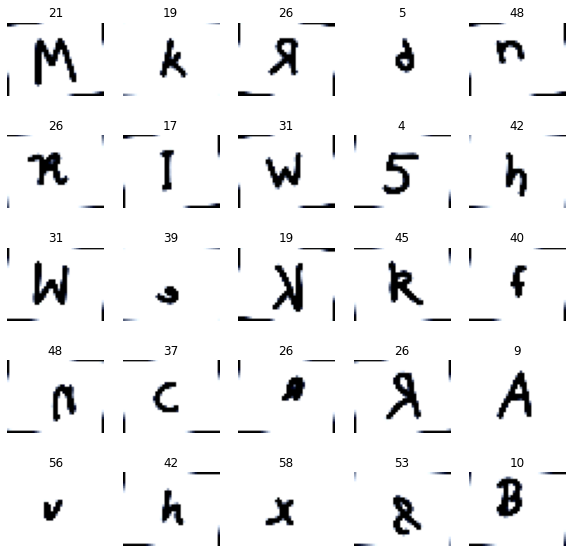

In [13]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = list(df['labels'].unique())
plot_images(images, labels, classes)

In [14]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2), #kernel_size
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [15]:
OUTPUT_DIM = 62
learning_rate = 1e-3
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
model = AlexNet(OUTPUT_DIM)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_iterator):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(targets.max())
        #print(targets.min())

        # forward
        scores, _ = model(data)
        #print(scores.shape)
        
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

Cost at epoch 0 is 4.123611014229911
Cost at epoch 1 is 3.8398344312395367
Cost at epoch 2 is 3.4723442929131645
Cost at epoch 3 is 3.286356544494629
Cost at epoch 4 is 3.12344925062997
Cost at epoch 5 is 3.0007486547742572
Cost at epoch 6 is 2.907680664743696
Cost at epoch 7 is 2.757235404423305
Cost at epoch 8 is 2.611342476095472
Cost at epoch 9 is 2.541632308278765


In [20]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores, _ = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

Checking accuracy on Training Set
Got 573 / 2232 with accuracy 25.67


In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_iterator, model)